In [1]:
from src import cpp_soft_info

# Load Data

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
from result_saver import SaverProvider
provider = SaverProvider()

In [4]:
import numpy as np
from Scratch import metadata_loader

DEVICE = 'ibm_torino'

md = metadata_loader(_extract=True, _drop_inutile=True)
# md = md[md["job_status"] == "JobStatus.DONE"]
# md = md[md["notebook_name"] == "bigger_rep_codes"]
max_distance = int(max(md.distance))
max_distance = 10
md = md[md["distance"] == max_distance]
md = md[md["backend_name"]==DEVICE]


md = md[md["shots"]==10000]
md = md[:2]

md

creation_date   notebook_name backend_name  \
2528  2023-12-02 11:16:20.667000+01:00  torino_repcode   ibm_torino   
2527  2023-12-02 11:16:18.322000+01:00  torino_repcode   ibm_torino   

                    job_id       tags  meas_level    shots tags_xp  rep_delay  \
2528  cnng7x70k0p00088v8vg  [RepCode]         1.0  10000.0     NaN        NaN   
2527  cnng7wq24wx0008fagdg  [RepCode]         1.0  10000.0     NaN        NaN   

     sampled_state  ...      job_status                    execution_date  \
2528           NaN  ...  JobStatus.DONE  2023-12-02 11:18:18.144738+01:00   
2527           NaN  ...  JobStatus.DONE  2023-12-02 11:16:48.914779+01:00   

     extra optimization_level                   code distance  rounds logical  \
2528   NaN                NaN  RepetitionCodeCircuit     10.0      10       1   
2527   NaN                NaN  RepetitionCodeCircuit     10.0      10       0   

                        layout           descr  
2528  _is_hex=True, sherbrooke  diff rounds v2  
2527  _is_hex=True, sherbrooke  diff rounds v2  

[2 rows x 21 columns]

In [5]:
memories = {}
jobs = {}
for job_id, logical in zip(md.job_id, md.logical):
    mmr_name = f"mmr_log_{logical}"
    memories[mmr_name] = provider.retrieve_job(job_id).result().get_memory()
    jobs[mmr_name] = job_id

memory_str = "mmr_log_1"
memory = memories[memory_str][:100]
job_id = jobs[memory_str]
print(memory.shape)

(100, 100)


# Initialize the code

In [6]:
import stim
import pymatching

from soft_info import get_repcode_layout, get_repcode_IQ_map
from Scratch import create_or_load_kde_grid

d = max_distance
synd_rounds = max_distance
synd_rounds = 10

circuit = stim.Circuit.generated("repetition_code:memory",
                                 distance=d,
                                 rounds=synd_rounds,
                                 after_clifford_depolarization=0.1)

model = circuit.detector_error_model(decompose_errors=True)

# layout = get_repcode_layout(distance=max_distance, backend=provider.get_backend(DEVICE), _is_hex=True)

##### TORINO ####
distance = max_distance
import pickle
with open('longest_path_torino.pkl', 'rb') as f:
    path = pickle.load(f)
bounded_path = path[:2 * distance - 1]
layout = bounded_path[1::2] + bounded_path[::2] 


qubit_mapping = get_repcode_IQ_map(layout, synd_rounds) #Hardcoded for repetition codes
# print(qubit_mapping)
# print(len(qubit_mapping))

In [7]:
other_date = None # if none then it will find the closest to the tobecalib_job date
# other_date = "2023-11-22T10:30:00" # "2023-11-22T" works too
grid_dict, processed_scaler_dict = create_or_load_kde_grid(provider, job_id, num_grid_points=5, 
                                                           num_std_dev=0.3, other_date=other_date)

# takes 10s

Specified job execution date: 2023-12-02 11:18:18.144738+01:00
Found jobs for backend ibm_torino with closest execution date 2023-12-02 09:12:35.042892+00:00.
Searching for ibm_torino and 23.12.02_09h11_5pts_0.3std


In [8]:
# get_counts
counts = cpp_soft_info.get_counts(memory, qubit_mapping, grid_dict, processed_scaler_dict, synd_rounds)

# Decode

In [9]:
matching = pymatching.Matching.from_detector_error_model(model)
# p_data = 6.869e-3 # mean sherbrooke noise
p_data = 6.869e-3
result = cpp_soft_info.decode_IQ_shots(matching._matching_graph, memory,
                                           synd_rounds, 1, False, qubit_mapping, grid_dict,
                                           processed_scaler_dict, p_data=p_data, p_mixed=p_data/1, #p_mixed=1e-80, for d=30
                                           common_measure=-1, _bimodal=False, merge_strategy = "replace", _detailed=True)
print("num_errors:", result.num_errors, "out of", len(memory), "shots")
 
# takes 5s

num_errors: 34 out of 100 shots


# Draw result

In [10]:
print(len(result.error_details)) # is the number of errors
print(len(result.error_details[0].edges)) # is the number of EDGES in the first error
print((result.error_details[0].edges[0].attributes.weight)) # get the WEIGHT
node1, node2, edge_data = result.error_details[0].edges[0].node1, result.error_details[0].edges[0].node2, result.error_details[0].edges[0].attributes
print(edge_data.weight, edge_data.error_probability, edge_data.fault_ids)
print((result.error_details[0].matched_edges)) # get the MATCHED EDGES
print((result.error_details[0].detection_syndromes)) # get the DETECTION SYNDROMES

print(result.indices)

34
280
4.973844051361084
4.973844051361084 0.05333333333333338 set()
[(59, 68), (65, 74), (65, 56), (93, 84), (57, 66), (85, 95), (75, 76), (58, 49), (3, 12), (30, 21), (38, 28), (38, 39), (5, 6), (8, -1), (9, -1), (53, -1), (54, 63), (80, 71), (80, 89), (81, -1)]
[0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0]
[1, 2, 3, 7, 9, 10, 14, 15, 17, 20, 21, 26, 27, 31, 35, 36, 39, 46, 47, 52, 54, 56, 58, 59, 60, 63, 69, 72, 78, 81, 94, 96, 97, 99]


In [11]:

from soft_info import draw_matching_graph

for i in range(len(result.error_details)-38):
    draw_matching_graph(matching=None, d=d, T=synd_rounds, syndromes=result.error_details[i].detection_syndromes,
                        matched_edges=result.error_details[i].matched_edges, figsize=(20,20), edge_list=result.error_details[i].edges)

# Other decodings

In [12]:
result_flat = cpp_soft_info.decode_IQ_shots_flat(matching._matching_graph, memory, 
                                           synd_rounds, 1, False, qubit_mapping, grid_dict, 
                                           processed_scaler_dict, _detailed = True)

print("num_errors:", result_flat.num_errors, "out of", len(memory), "shots")

num_errors: 42 out of 100 shots


In [13]:
matching = pymatching.Matching.from_detector_error_model(model)

def weight_to_prob(weight):
    return 1/(1+np.exp(weight))

p_data = 6.869e-3 # mean sherbrooke ECR error
p_mixed = p_data/1 # Same as weighted
p_meas = 1e-10 # mean Readout assignment error

result_informed = cpp_soft_info.decode_IQ_shots_flat_informed(matching._matching_graph, memory, 
                                           synd_rounds, 1, False, qubit_mapping, grid_dict, processed_scaler_dict,
                                           p_data, p_mixed, p_meas, common_measure=-1, _detailed=True)
                                        
print("num_errors:", result_informed.num_errors, "out of", len(memory), "shots")
         
# takes 1s

num_errors: 45 out of 100 shots


# Compare decodings

In [14]:
from soft_info import draw_matching_graph

print(result.indices)
print(result_flat.indices)
print(result_informed.indices)

# print the difference between the lists
print("Difference between the lists result & result_flat:")
diff_1 = list(set(result.indices) - set(result_flat.indices))
print(diff_1)
print("Difference between the lists result & result_informed:")
diff_2 = list(set(result.indices) - set(result_informed.indices))
print(diff_2)


print("\nCommon errors between all lists:")
common = list(set(result.indices) & set(result_flat.indices) & set(result_informed.indices))
print(common)

[1, 2, 3, 7, 9, 10, 14, 15, 17, 20, 21, 26, 27, 31, 35, 36, 39, 46, 47, 52, 54, 56, 58, 59, 60, 63, 69, 72, 78, 81, 94, 96, 97, 99]
[1, 2, 3, 7, 9, 10, 13, 14, 17, 20, 21, 22, 26, 28, 31, 33, 36, 38, 43, 44, 47, 52, 54, 55, 56, 57, 60, 61, 62, 66, 69, 72, 73, 78, 79, 81, 86, 89, 90, 91, 94, 96]
[1, 2, 3, 4, 10, 11, 17, 20, 22, 24, 26, 28, 31, 33, 34, 35, 36, 38, 39, 40, 42, 43, 45, 48, 52, 53, 54, 56, 57, 60, 61, 62, 65, 66, 70, 72, 78, 79, 81, 82, 85, 86, 88, 89, 98]
Difference between the lists result & result_flat:
[97, 35, 99, 39, 59, 46, 15, 58, 27, 63]
Difference between the lists result & result_informed:
[96, 97, 99, 69, 7, 9, 59, 14, 15, 46, 47, 21, 58, 27, 94, 63]

Common errors between all lists:
[1, 2, 3, 36, 72, 10, 78, 17, 81, 20, 52, 54, 56, 26, 60, 31]


In [25]:
from IPython.core.display import HTML

# Scale the notebook display. 1.0 is 100%, 1.5 is 150%, etc.
scale_factor = '0.5'

HTML(f'''
<style>
    .output_png img {{
        display: block;
        margin-left: auto;
        margin-right: auto;
        width: {scale_factor}em;
    }}
</style>
''')


For common indices 1 in all lists: [1, 2, 3, 36, 72, 10, 78, 17, 81, 20, 52, 54, 56, 26, 60, 31]

result IQ:
Error 1 is at index 0 of [1, 2, 3, 7, 9, 10, 14, 15, 17, 20, 21, 26, 27, 31, 35, 36, 39, 46, 47, 52, 54, 56, 58, 59, 60, 63, 69, 72, 78, 81, 94, 96, 97, 99]


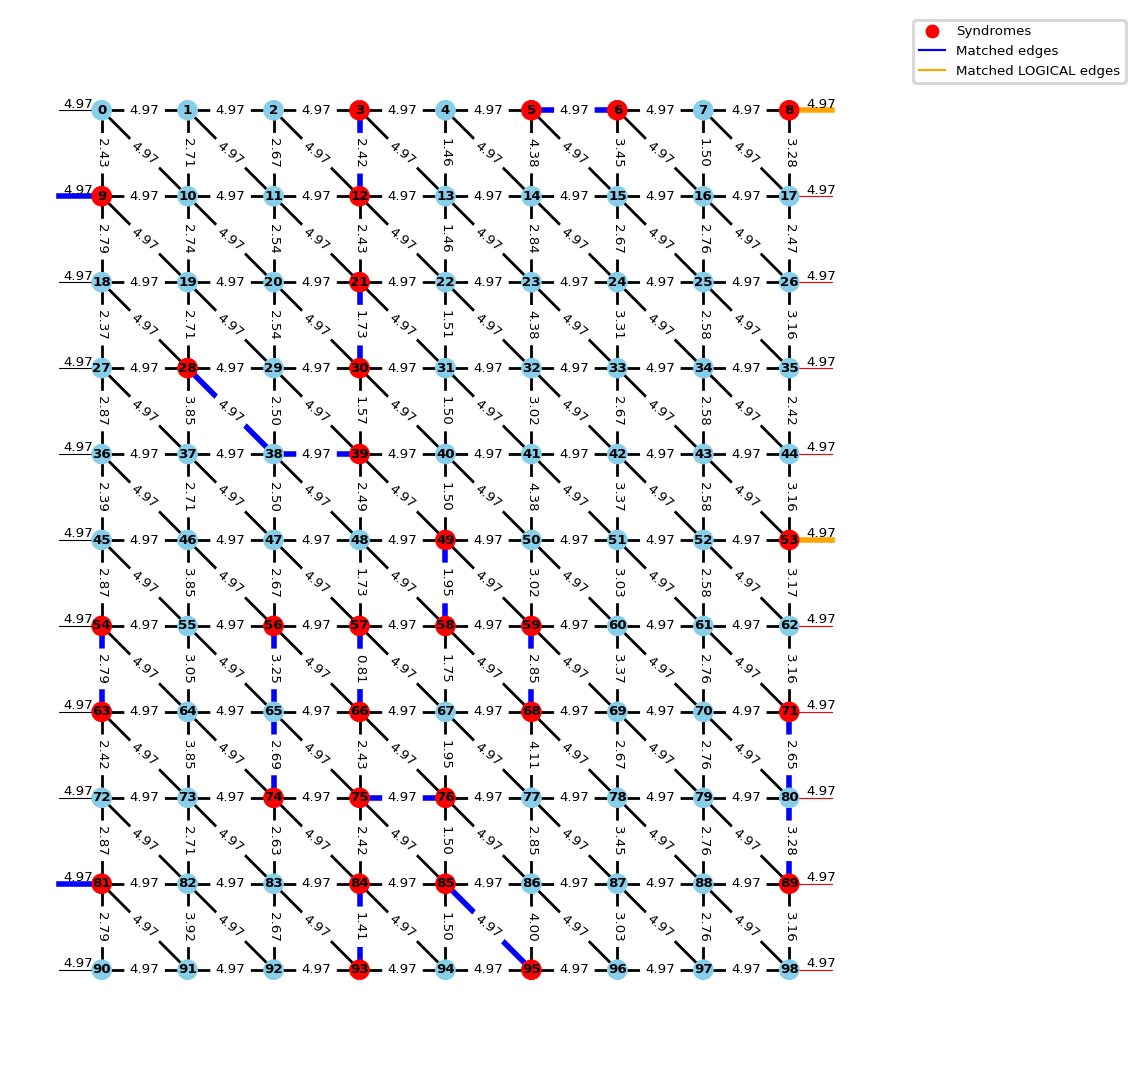


result_flat:
Error 1 is at index 0 of [1, 2, 3, 7, 9, 10, 13, 14, 17, 20, 21, 22, 26, 28, 31, 33, 36, 38, 43, 44, 47, 52, 54, 55, 56, 57, 60, 61, 62, 66, 69, 72, 73, 78, 79, 81, 86, 89, 90, 91, 94, 96]


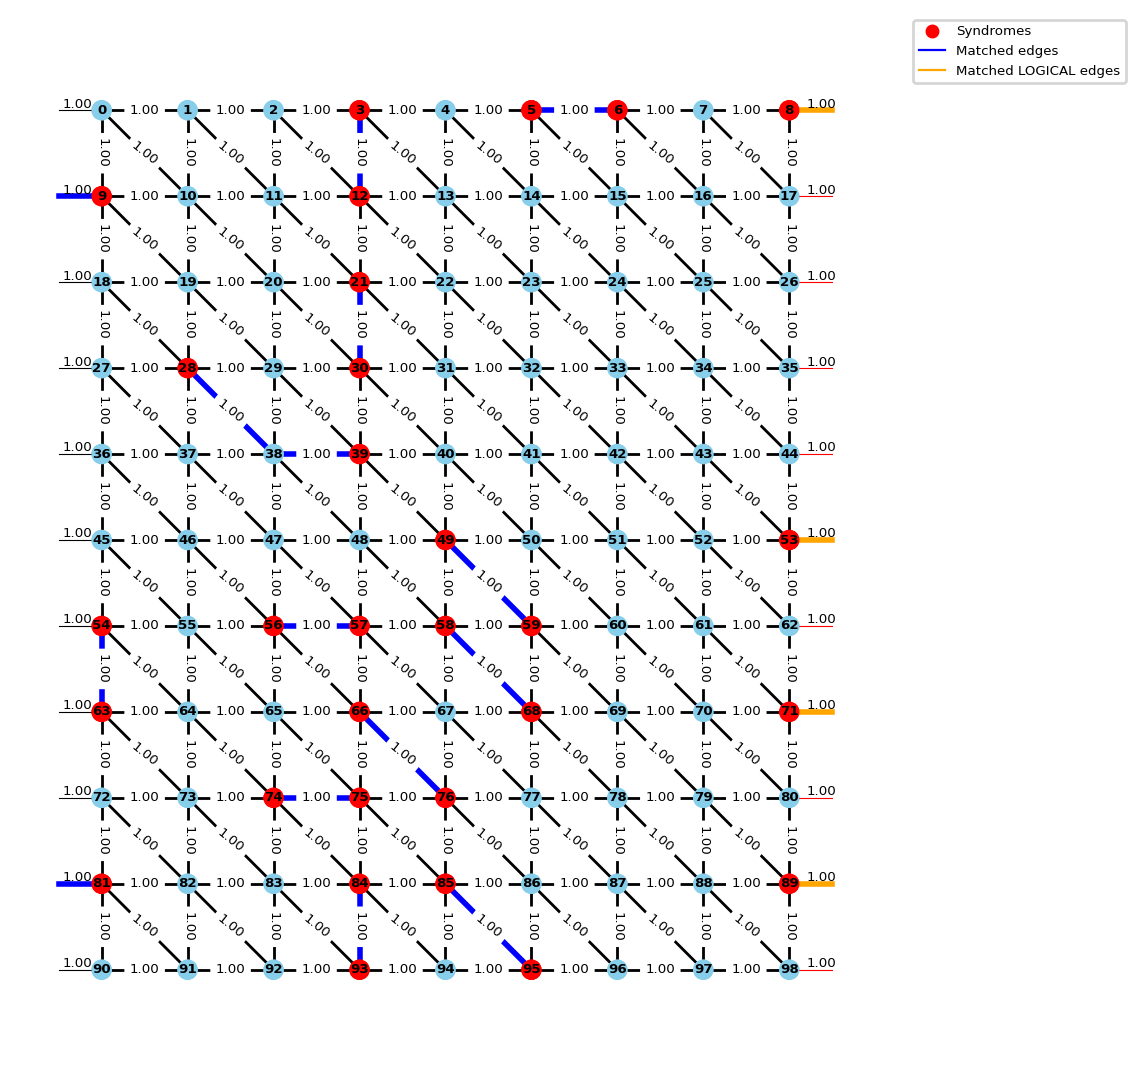


result_informed:
45 45
Error 1 is at index 0 of [1, 2, 3, 4, 10, 11, 17, 20, 22, 24, 26, 28, 31, 33, 34, 35, 36, 38, 39, 40, 42, 43, 45, 48, 52, 53, 54, 56, 57, 60, 61, 62, 65, 66, 70, 72, 78, 79, 81, 82, 85, 86, 88, 89, 98]


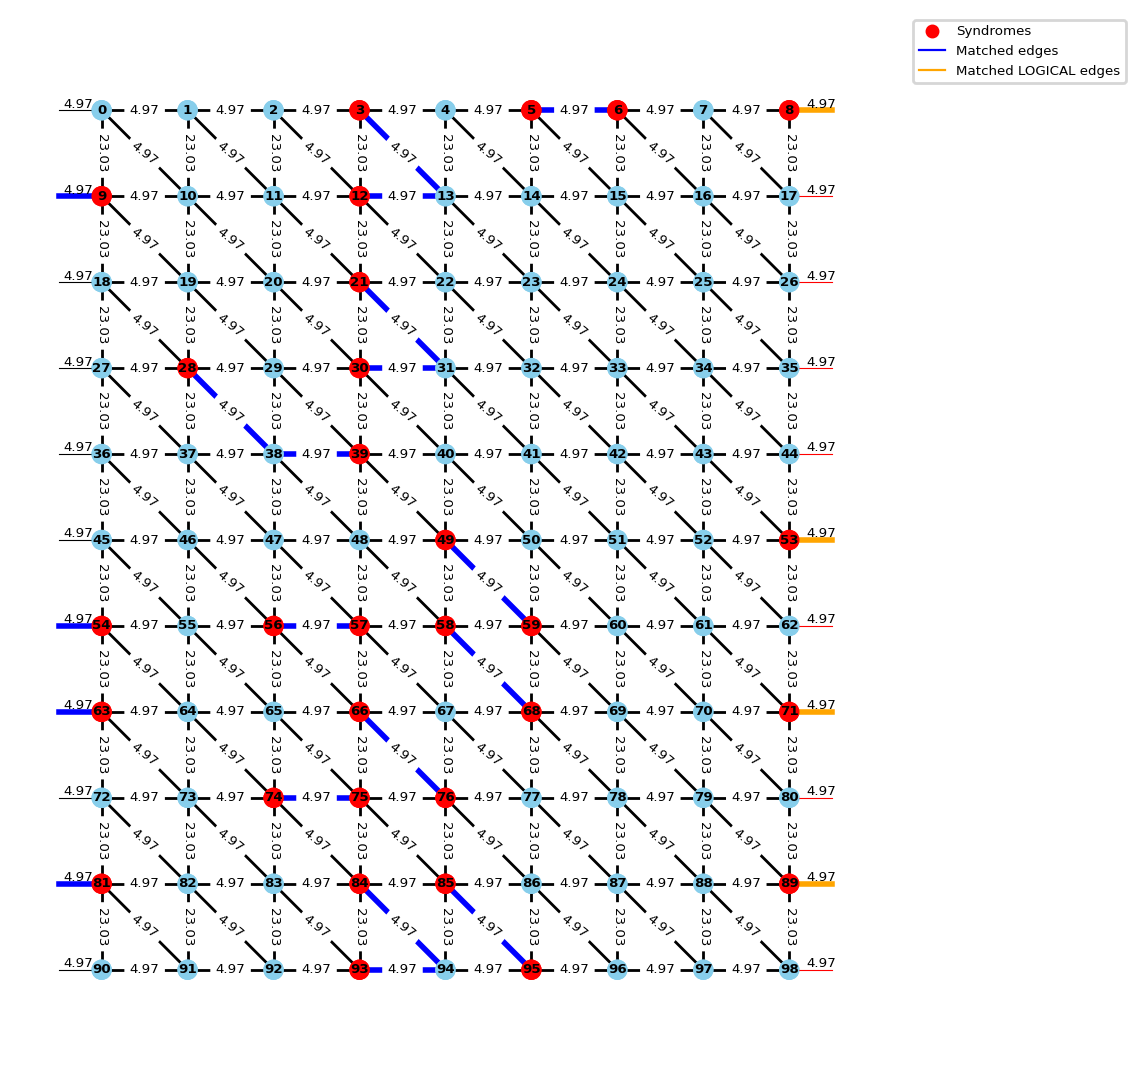

For common indices 2 in all lists: [1, 2, 3, 36, 72, 10, 78, 17, 81, 20, 52, 54, 56, 26, 60, 31]

result IQ:
Error 2 is at index 1 of [1, 2, 3, 7, 9, 10, 14, 15, 17, 20, 21, 26, 27, 31, 35, 36, 39, 46, 47, 52, 54, 56, 58, 59, 60, 63, 69, 72, 78, 81, 94, 96, 97, 99]


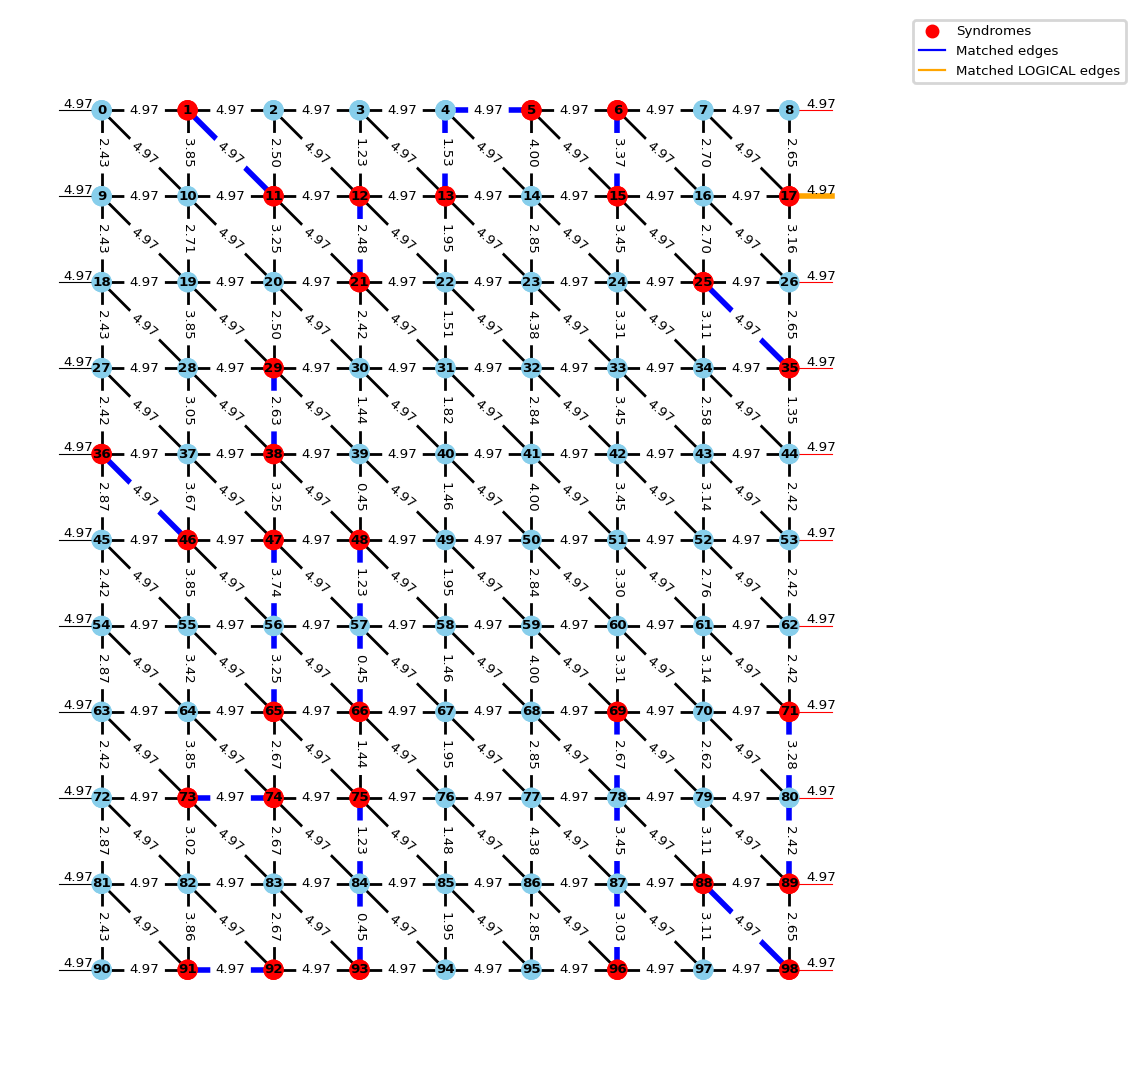


result_flat:
Error 2 is at index 1 of [1, 2, 3, 7, 9, 10, 13, 14, 17, 20, 21, 22, 26, 28, 31, 33, 36, 38, 43, 44, 47, 52, 54, 55, 56, 57, 60, 61, 62, 66, 69, 72, 73, 78, 79, 81, 86, 89, 90, 91, 94, 96]


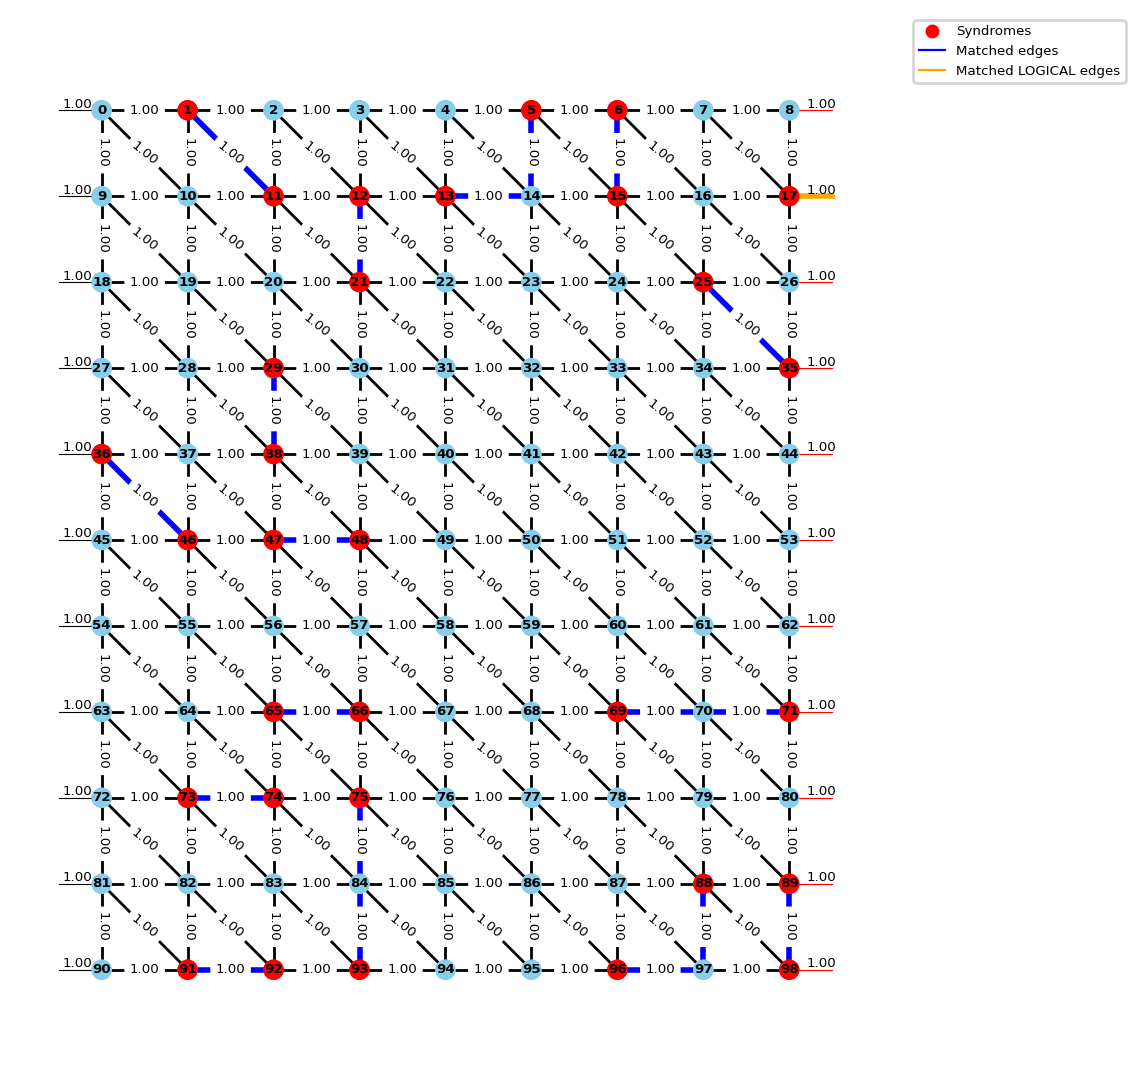


result_informed:
45 45
Error 2 is at index 1 of [1, 2, 3, 4, 10, 11, 17, 20, 22, 24, 26, 28, 31, 33, 34, 35, 36, 38, 39, 40, 42, 43, 45, 48, 52, 53, 54, 56, 57, 60, 61, 62, 65, 66, 70, 72, 78, 79, 81, 82, 85, 86, 88, 89, 98]


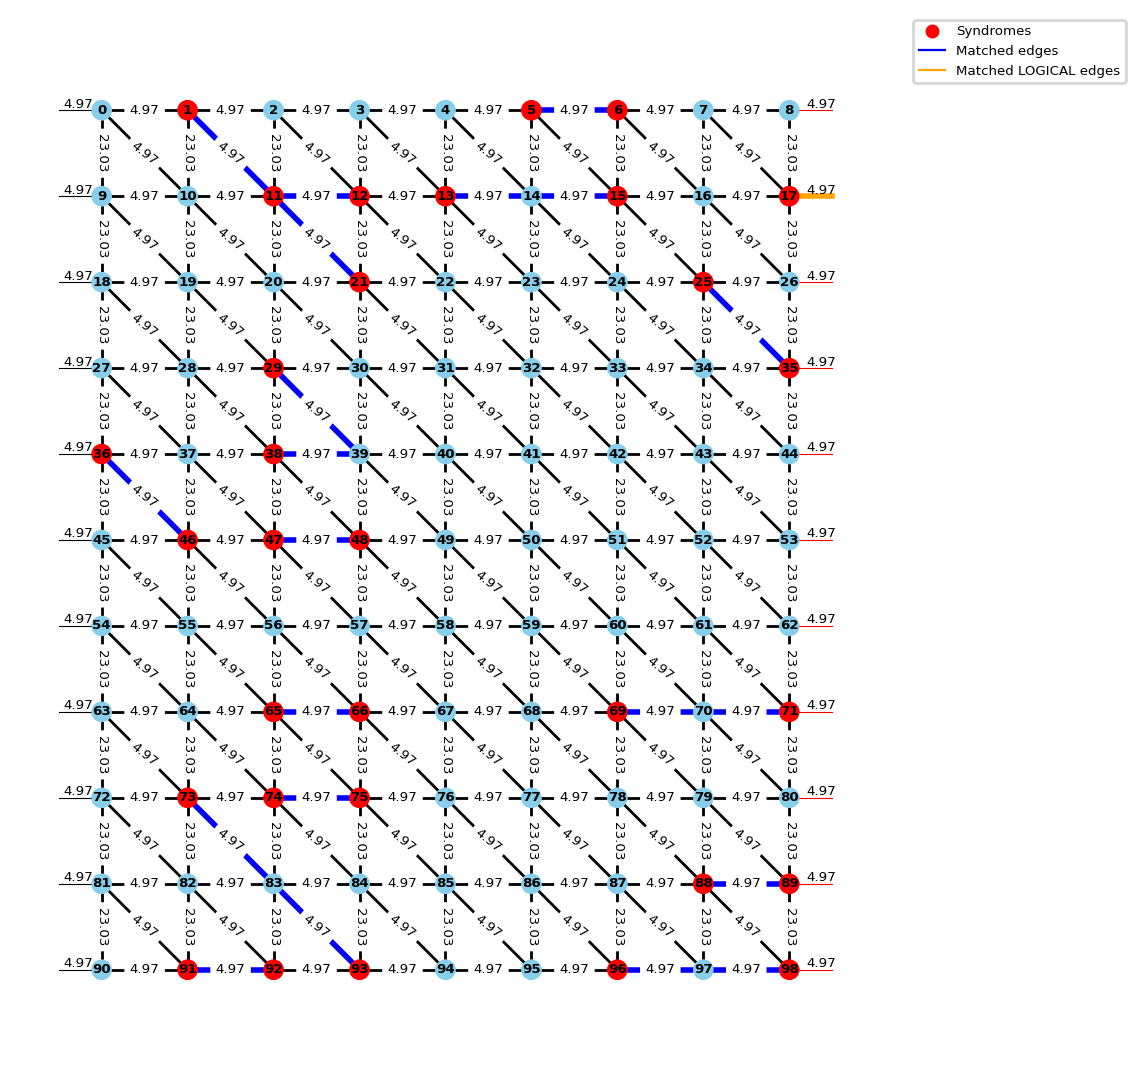

For common indices 3 in all lists: [1, 2, 3, 36, 72, 10, 78, 17, 81, 20, 52, 54, 56, 26, 60, 31]

result IQ:
Error 3 is at index 2 of [1, 2, 3, 7, 9, 10, 14, 15, 17, 20, 21, 26, 27, 31, 35, 36, 39, 46, 47, 52, 54, 56, 58, 59, 60, 63, 69, 72, 78, 81, 94, 96, 97, 99]


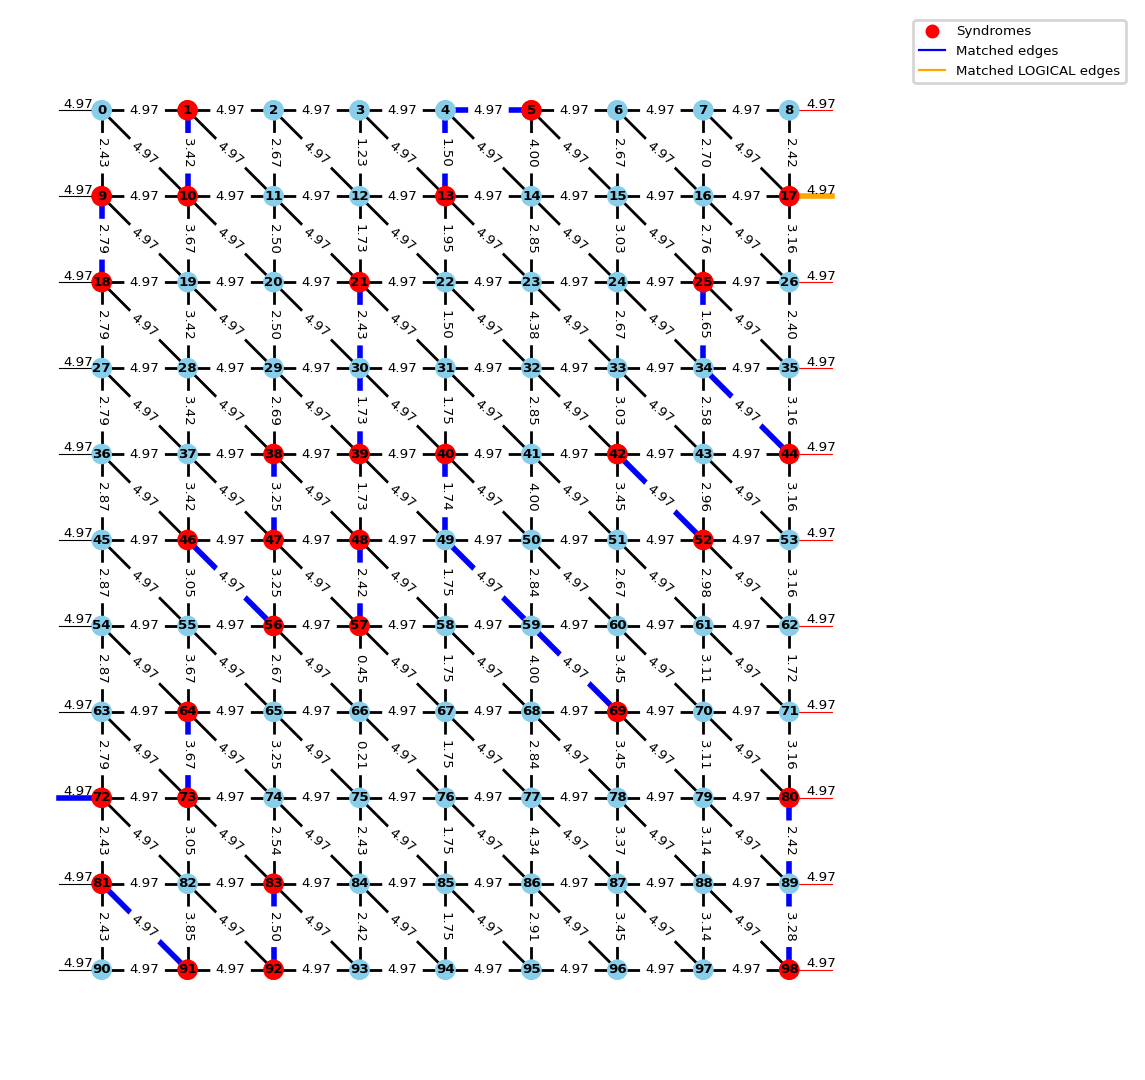


result_flat:
Error 3 is at index 2 of [1, 2, 3, 7, 9, 10, 13, 14, 17, 20, 21, 22, 26, 28, 31, 33, 36, 38, 43, 44, 47, 52, 54, 55, 56, 57, 60, 61, 62, 66, 69, 72, 73, 78, 79, 81, 86, 89, 90, 91, 94, 96]


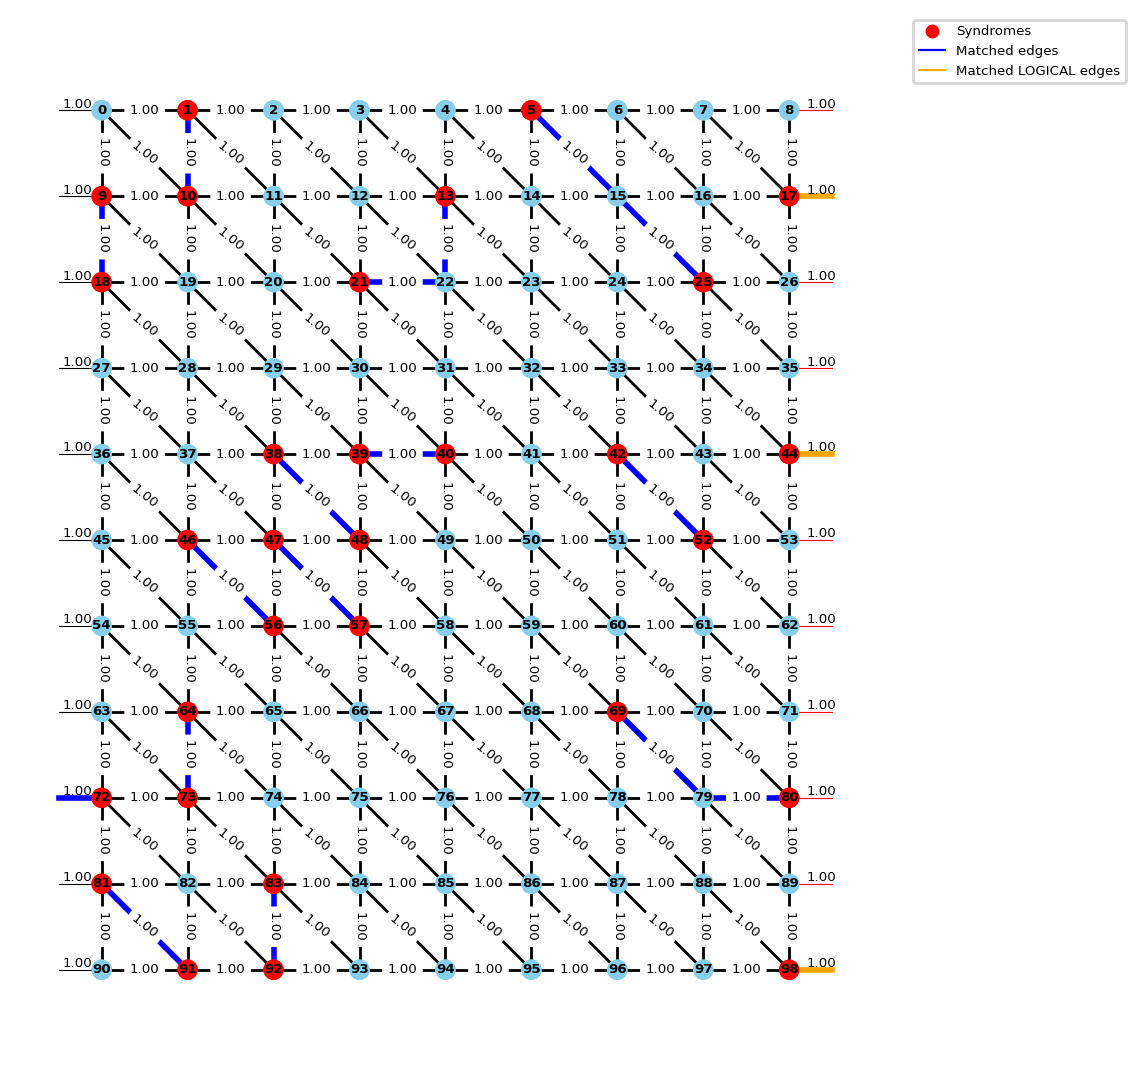


result_informed:
45 45
Error 3 is at index 2 of [1, 2, 3, 4, 10, 11, 17, 20, 22, 24, 26, 28, 31, 33, 34, 35, 36, 38, 39, 40, 42, 43, 45, 48, 52, 53, 54, 56, 57, 60, 61, 62, 65, 66, 70, 72, 78, 79, 81, 82, 85, 86, 88, 89, 98]


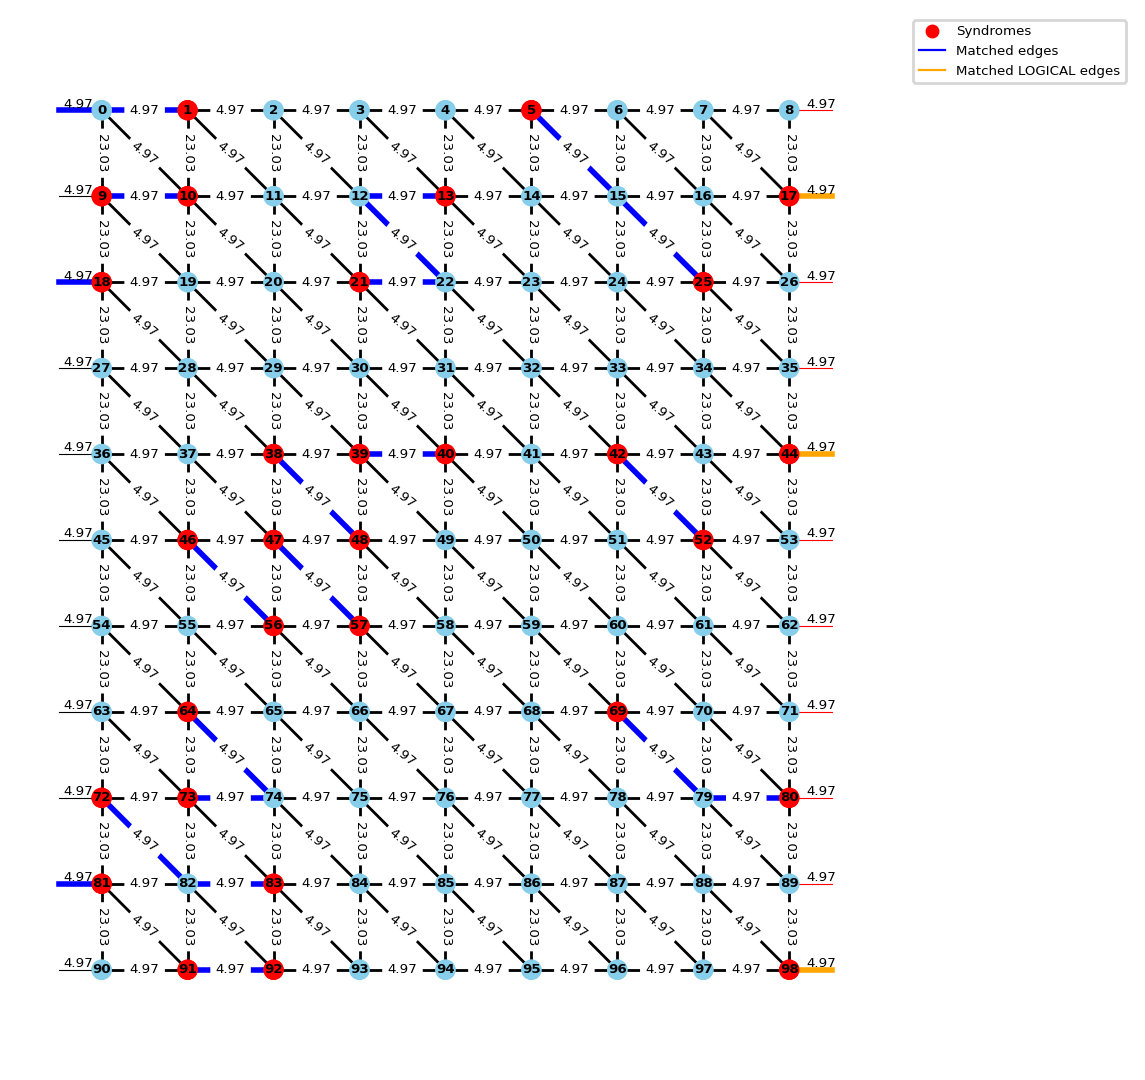

For common indices 36 in all lists: [1, 2, 3, 36, 72, 10, 78, 17, 81, 20, 52, 54, 56, 26, 60, 31]

result IQ:
Error 36 is at index 15 of [1, 2, 3, 7, 9, 10, 14, 15, 17, 20, 21, 26, 27, 31, 35, 36, 39, 46, 47, 52, 54, 56, 58, 59, 60, 63, 69, 72, 78, 81, 94, 96, 97, 99]


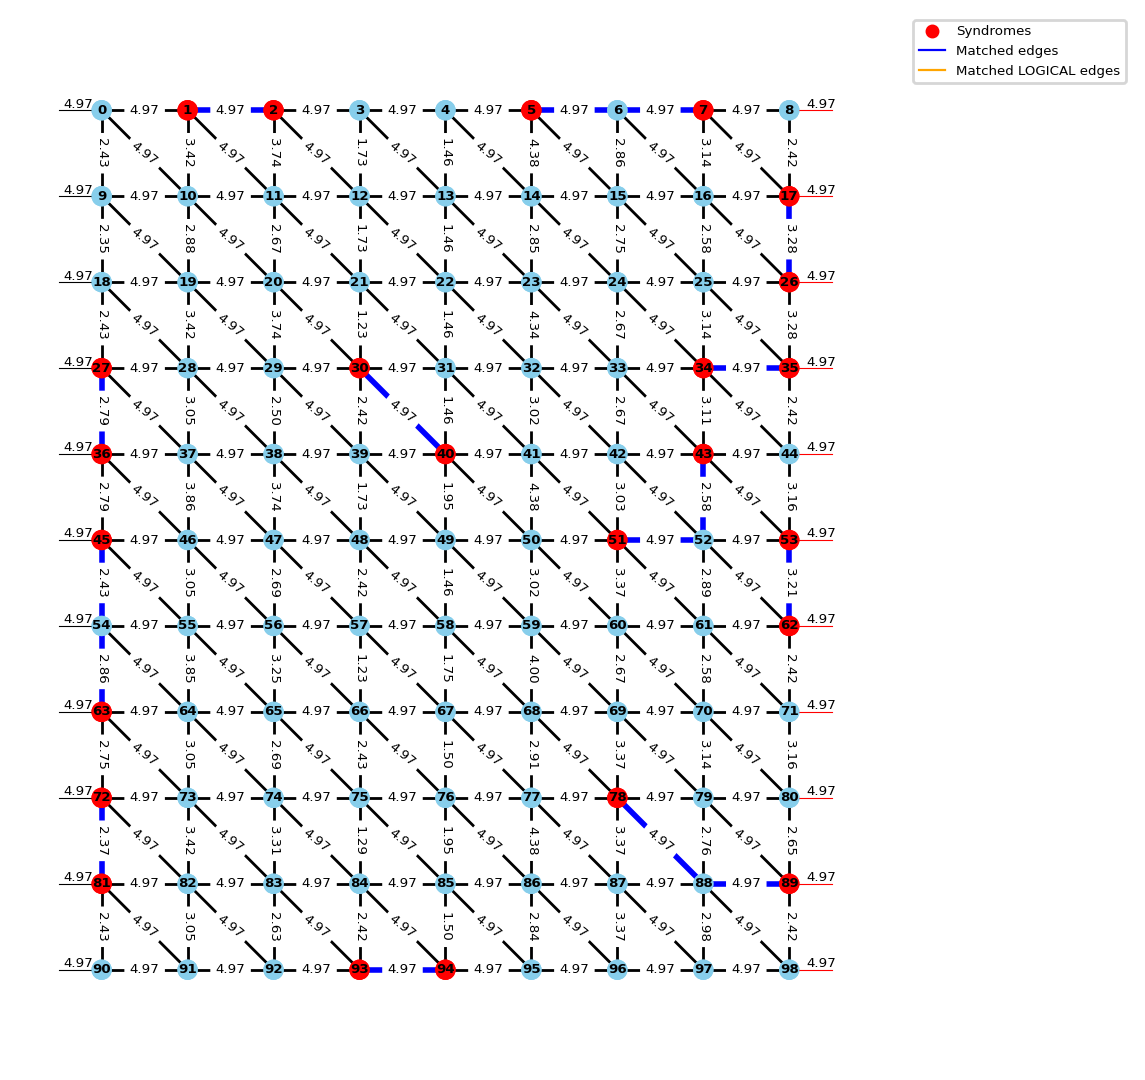


result_flat:
Error 36 is at index 16 of [1, 2, 3, 7, 9, 10, 13, 14, 17, 20, 21, 22, 26, 28, 31, 33, 36, 38, 43, 44, 47, 52, 54, 55, 56, 57, 60, 61, 62, 66, 69, 72, 73, 78, 79, 81, 86, 89, 90, 91, 94, 96]


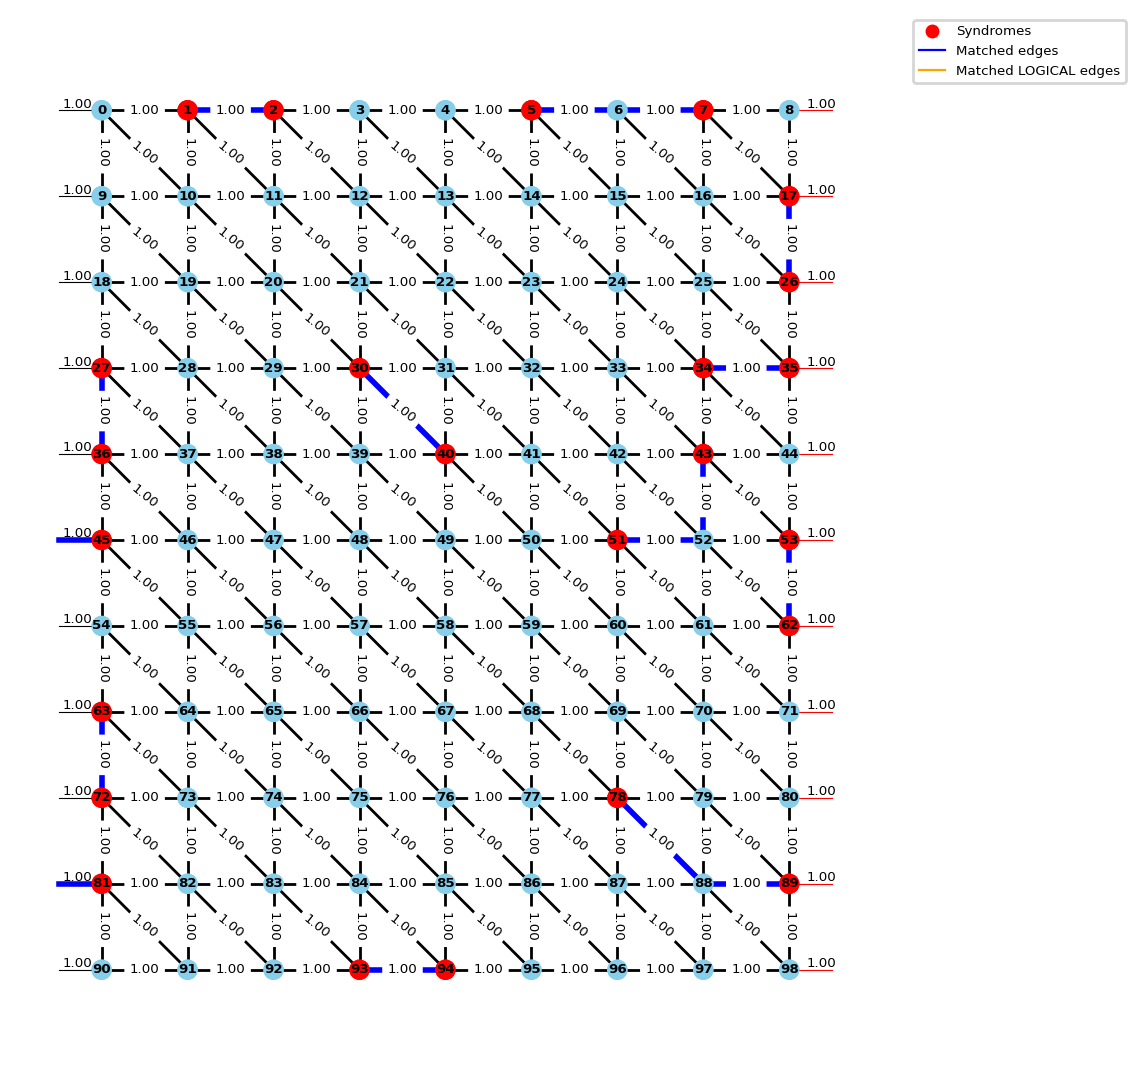


result_informed:
45 45
Error 36 is at index 16 of [1, 2, 3, 4, 10, 11, 17, 20, 22, 24, 26, 28, 31, 33, 34, 35, 36, 38, 39, 40, 42, 43, 45, 48, 52, 53, 54, 56, 57, 60, 61, 62, 65, 66, 70, 72, 78, 79, 81, 82, 85, 86, 88, 89, 98]


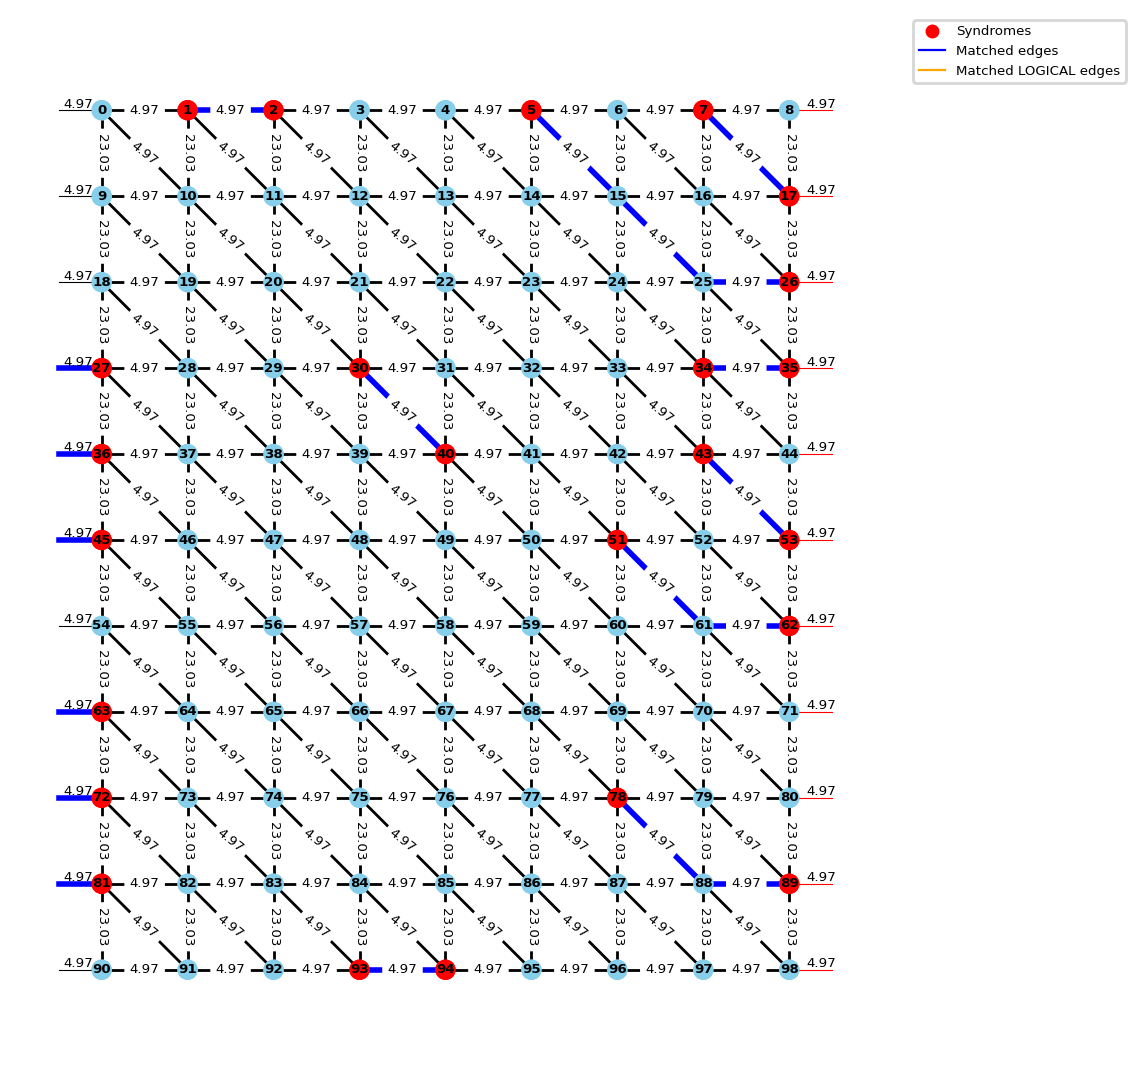

For common indices 72 in all lists: [1, 2, 3, 36, 72, 10, 78, 17, 81, 20, 52, 54, 56, 26, 60, 31]

result IQ:
Error 72 is at index 27 of [1, 2, 3, 7, 9, 10, 14, 15, 17, 20, 21, 26, 27, 31, 35, 36, 39, 46, 47, 52, 54, 56, 58, 59, 60, 63, 69, 72, 78, 81, 94, 96, 97, 99]


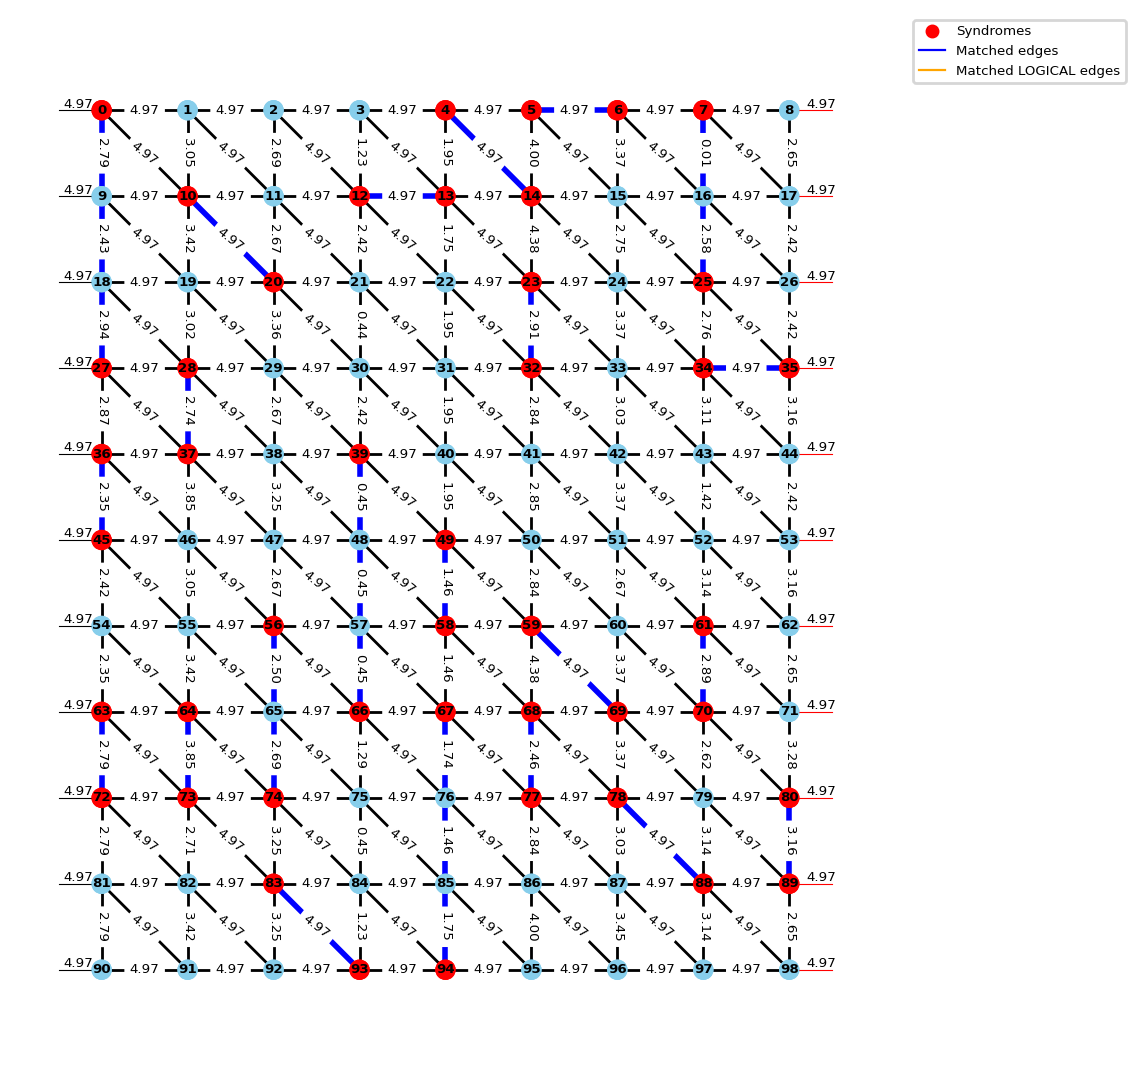


result_flat:
Error 72 is at index 31 of [1, 2, 3, 7, 9, 10, 13, 14, 17, 20, 21, 22, 26, 28, 31, 33, 36, 38, 43, 44, 47, 52, 54, 55, 56, 57, 60, 61, 62, 66, 69, 72, 73, 78, 79, 81, 86, 89, 90, 91, 94, 96]


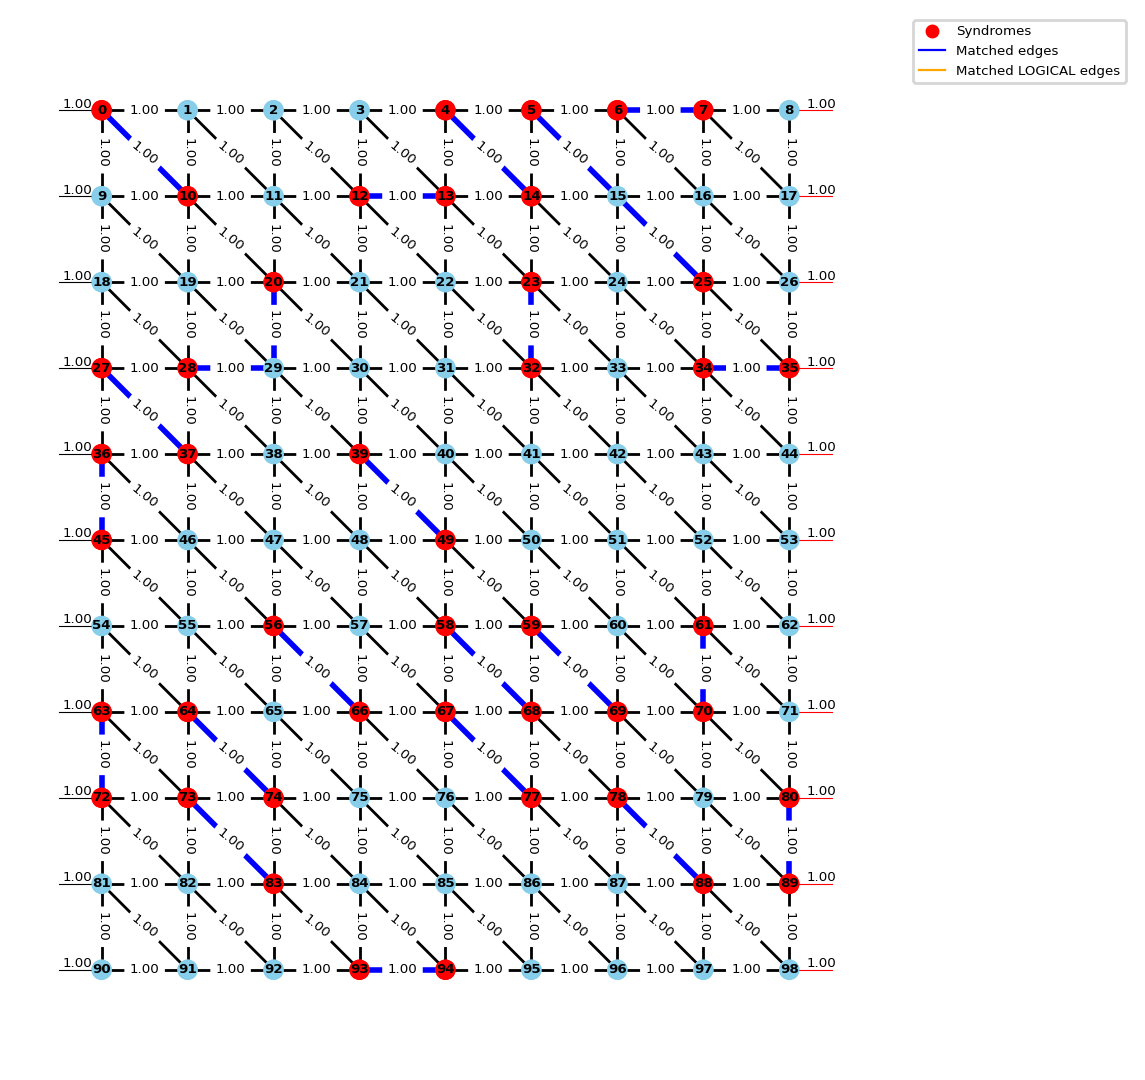


result_informed:
45 45
Error 72 is at index 35 of [1, 2, 3, 4, 10, 11, 17, 20, 22, 24, 26, 28, 31, 33, 34, 35, 36, 38, 39, 40, 42, 43, 45, 48, 52, 53, 54, 56, 57, 60, 61, 62, 65, 66, 70, 72, 78, 79, 81, 82, 85, 86, 88, 89, 98]


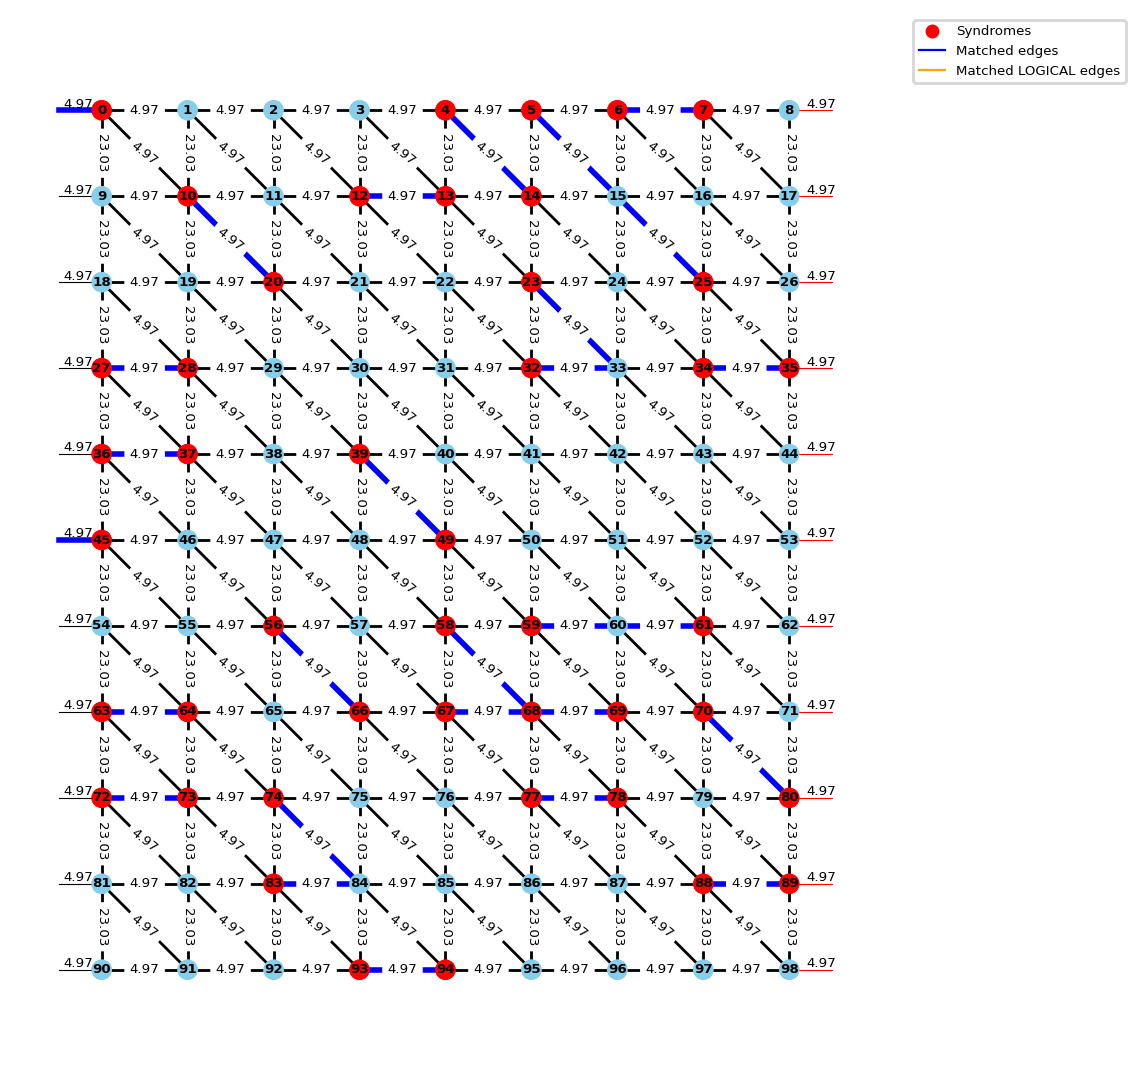

For common indices 10 in all lists: [1, 2, 3, 36, 72, 10, 78, 17, 81, 20, 52, 54, 56, 26, 60, 31]

result IQ:
Error 10 is at index 5 of [1, 2, 3, 7, 9, 10, 14, 15, 17, 20, 21, 26, 27, 31, 35, 36, 39, 46, 47, 52, 54, 56, 58, 59, 60, 63, 69, 72, 78, 81, 94, 96, 97, 99]


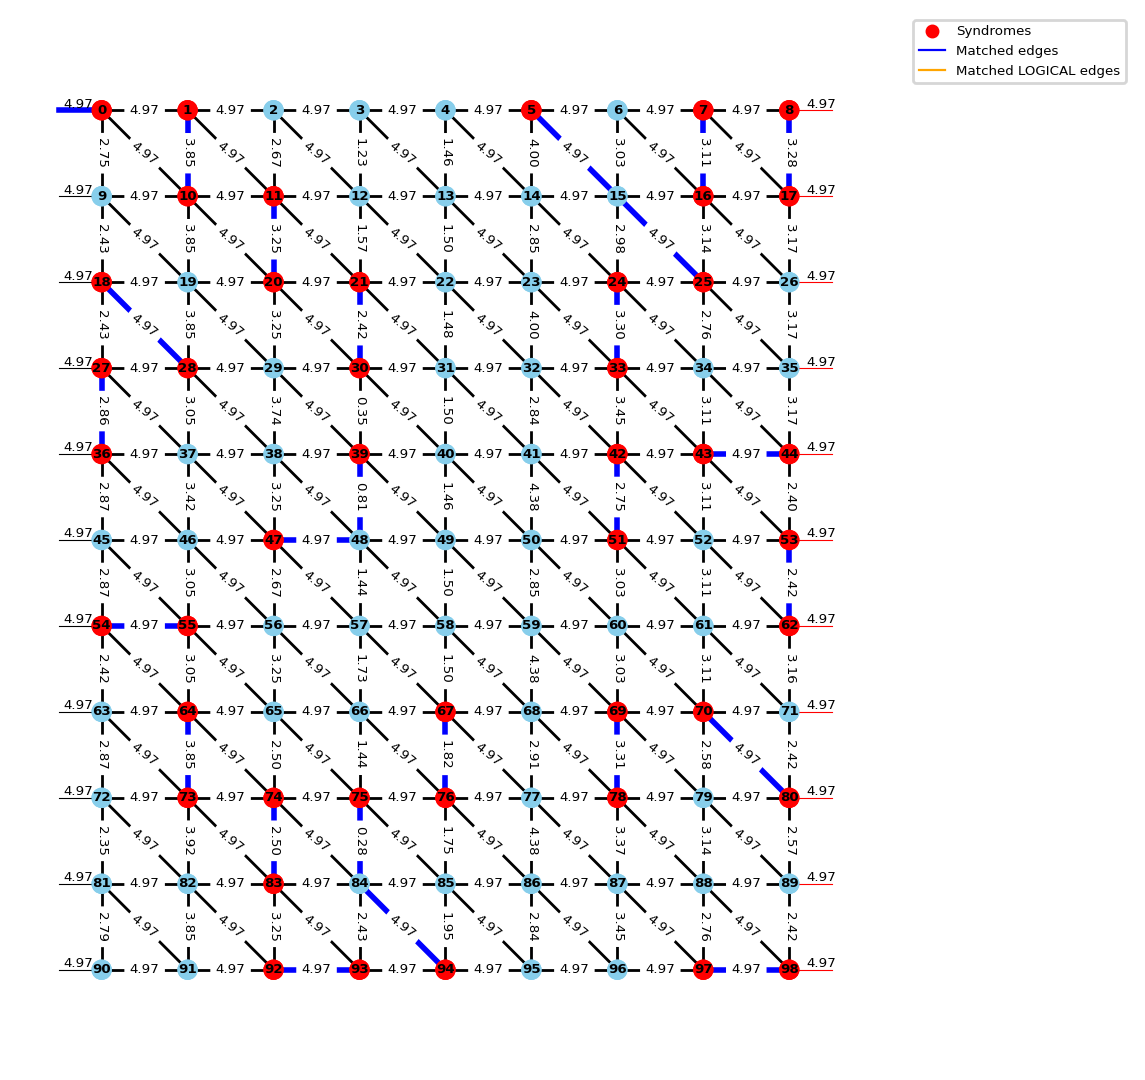


result_flat:
Error 10 is at index 5 of [1, 2, 3, 7, 9, 10, 13, 14, 17, 20, 21, 22, 26, 28, 31, 33, 36, 38, 43, 44, 47, 52, 54, 55, 56, 57, 60, 61, 62, 66, 69, 72, 73, 78, 79, 81, 86, 89, 90, 91, 94, 96]


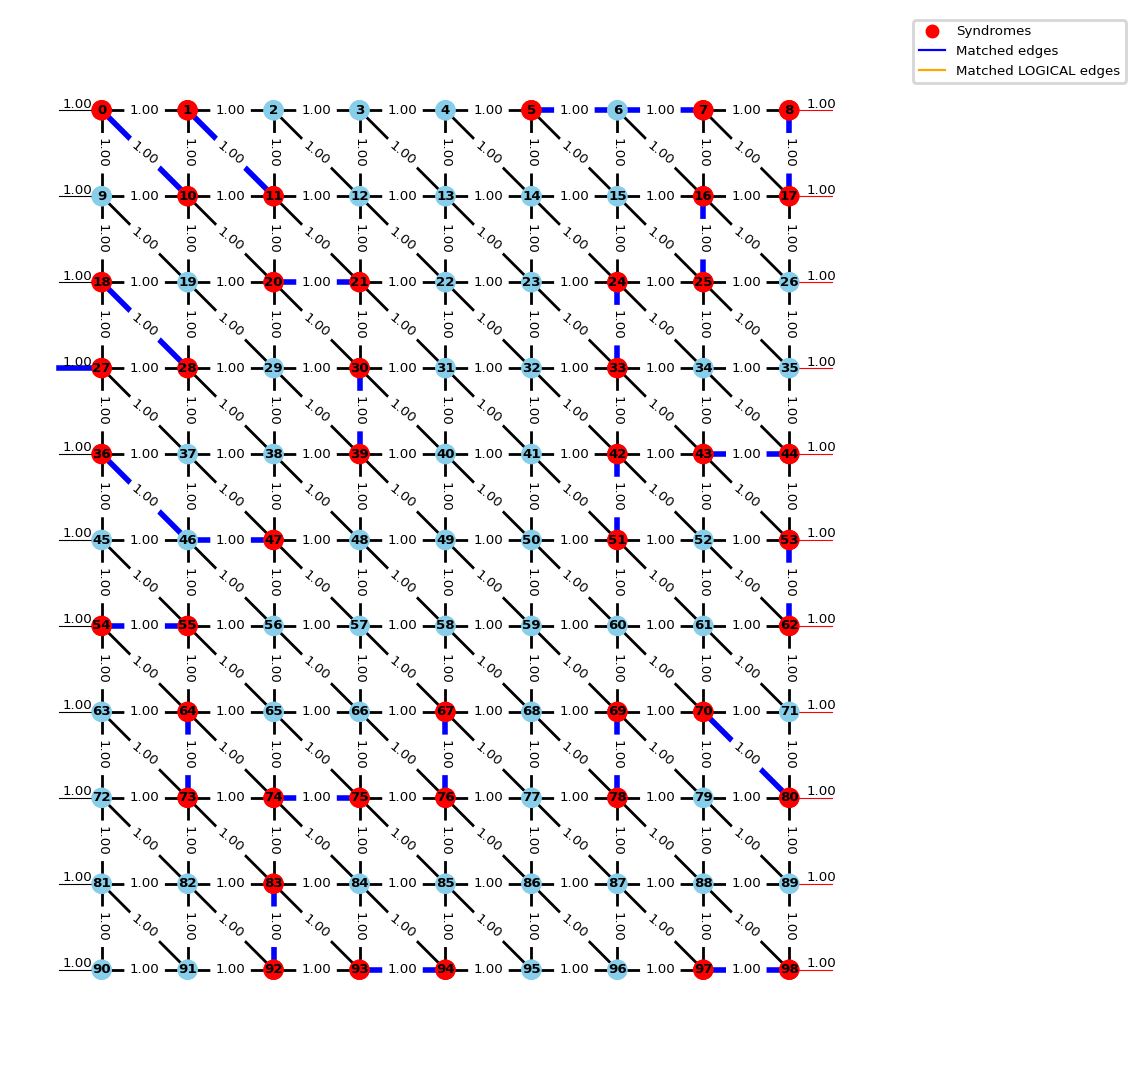


result_informed:
45 45
Error 10 is at index 4 of [1, 2, 3, 4, 10, 11, 17, 20, 22, 24, 26, 28, 31, 33, 34, 35, 36, 38, 39, 40, 42, 43, 45, 48, 52, 53, 54, 56, 57, 60, 61, 62, 65, 66, 70, 72, 78, 79, 81, 82, 85, 86, 88, 89, 98]


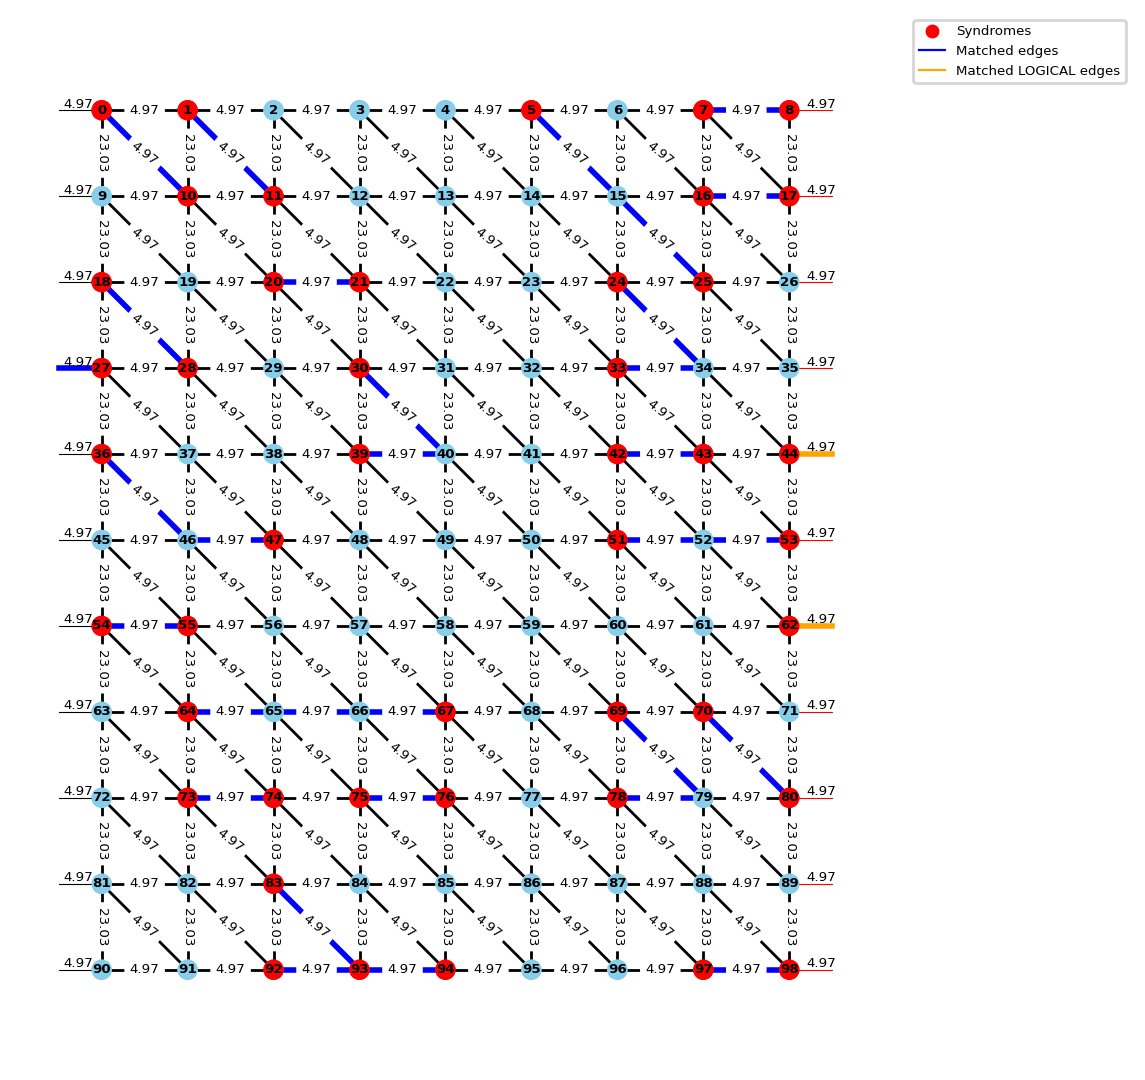

For common indices 78 in all lists: [1, 2, 3, 36, 72, 10, 78, 17, 81, 20, 52, 54, 56, 26, 60, 31]

result IQ:
Error 78 is at index 28 of [1, 2, 3, 7, 9, 10, 14, 15, 17, 20, 21, 26, 27, 31, 35, 36, 39, 46, 47, 52, 54, 56, 58, 59, 60, 63, 69, 72, 78, 81, 94, 96, 97, 99]


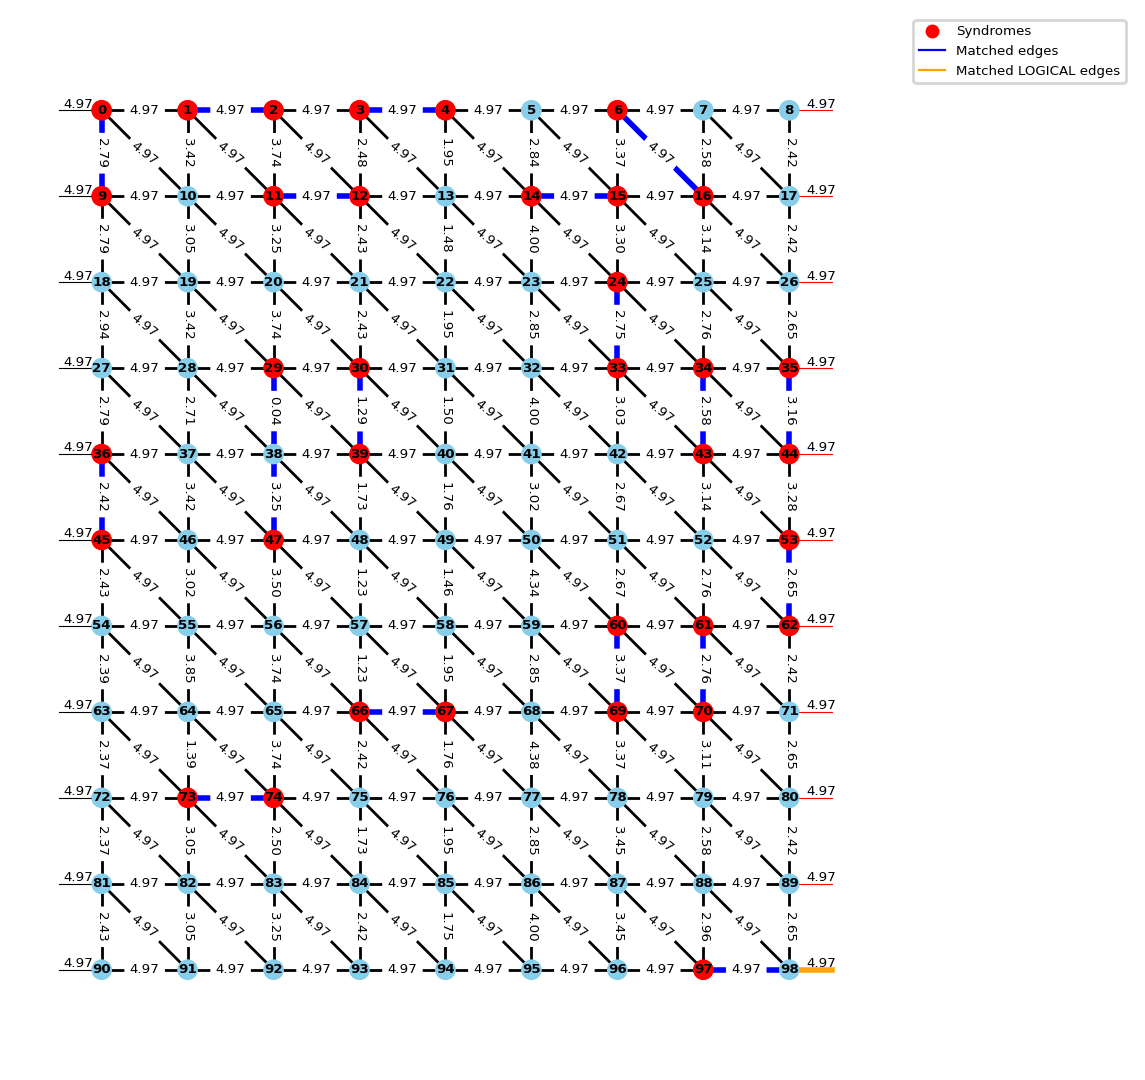


result_flat:
Error 78 is at index 33 of [1, 2, 3, 7, 9, 10, 13, 14, 17, 20, 21, 22, 26, 28, 31, 33, 36, 38, 43, 44, 47, 52, 54, 55, 56, 57, 60, 61, 62, 66, 69, 72, 73, 78, 79, 81, 86, 89, 90, 91, 94, 96]


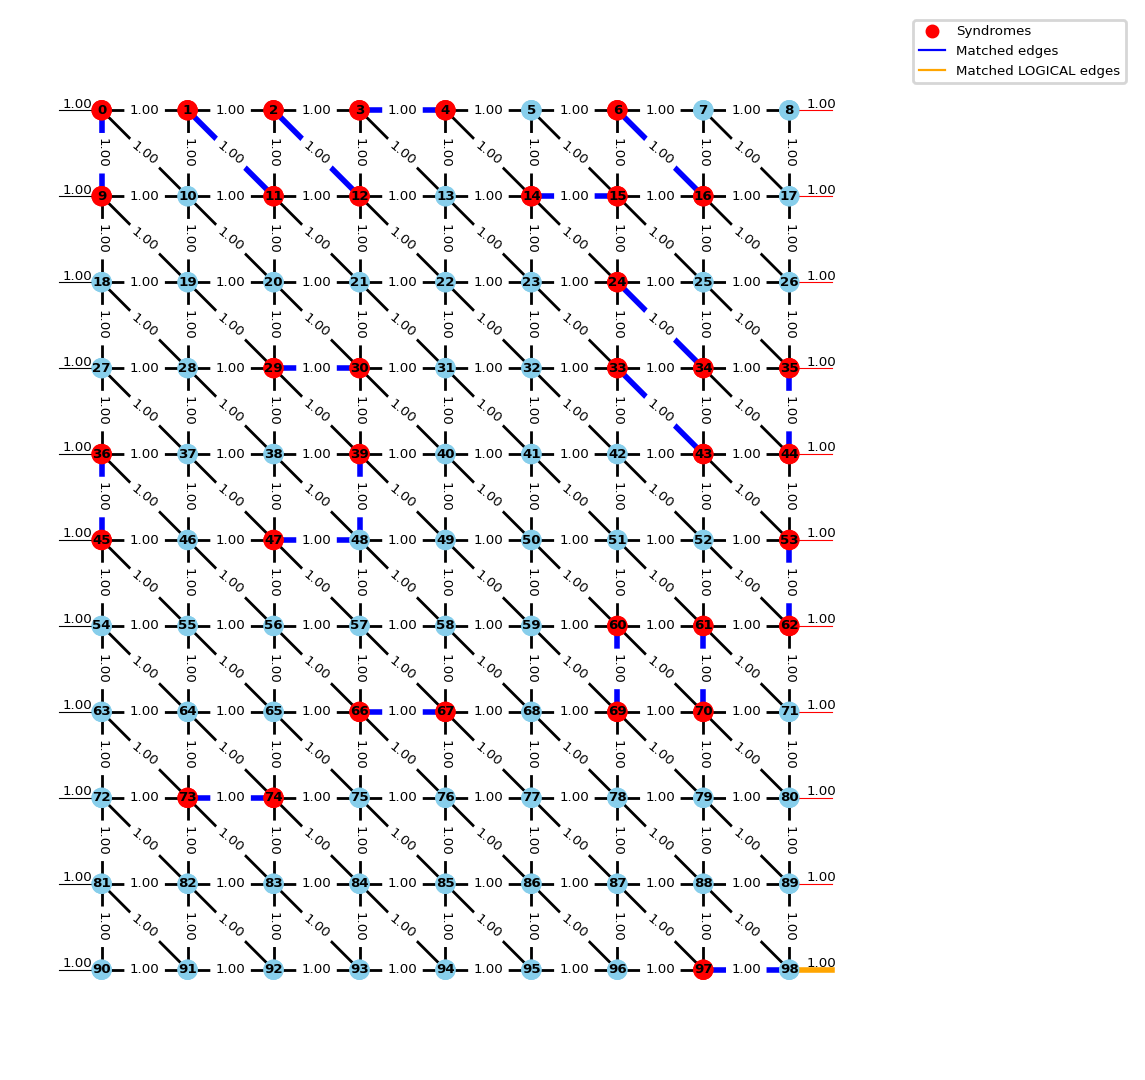


result_informed:
45 45
Error 78 is at index 36 of [1, 2, 3, 4, 10, 11, 17, 20, 22, 24, 26, 28, 31, 33, 34, 35, 36, 38, 39, 40, 42, 43, 45, 48, 52, 53, 54, 56, 57, 60, 61, 62, 65, 66, 70, 72, 78, 79, 81, 82, 85, 86, 88, 89, 98]


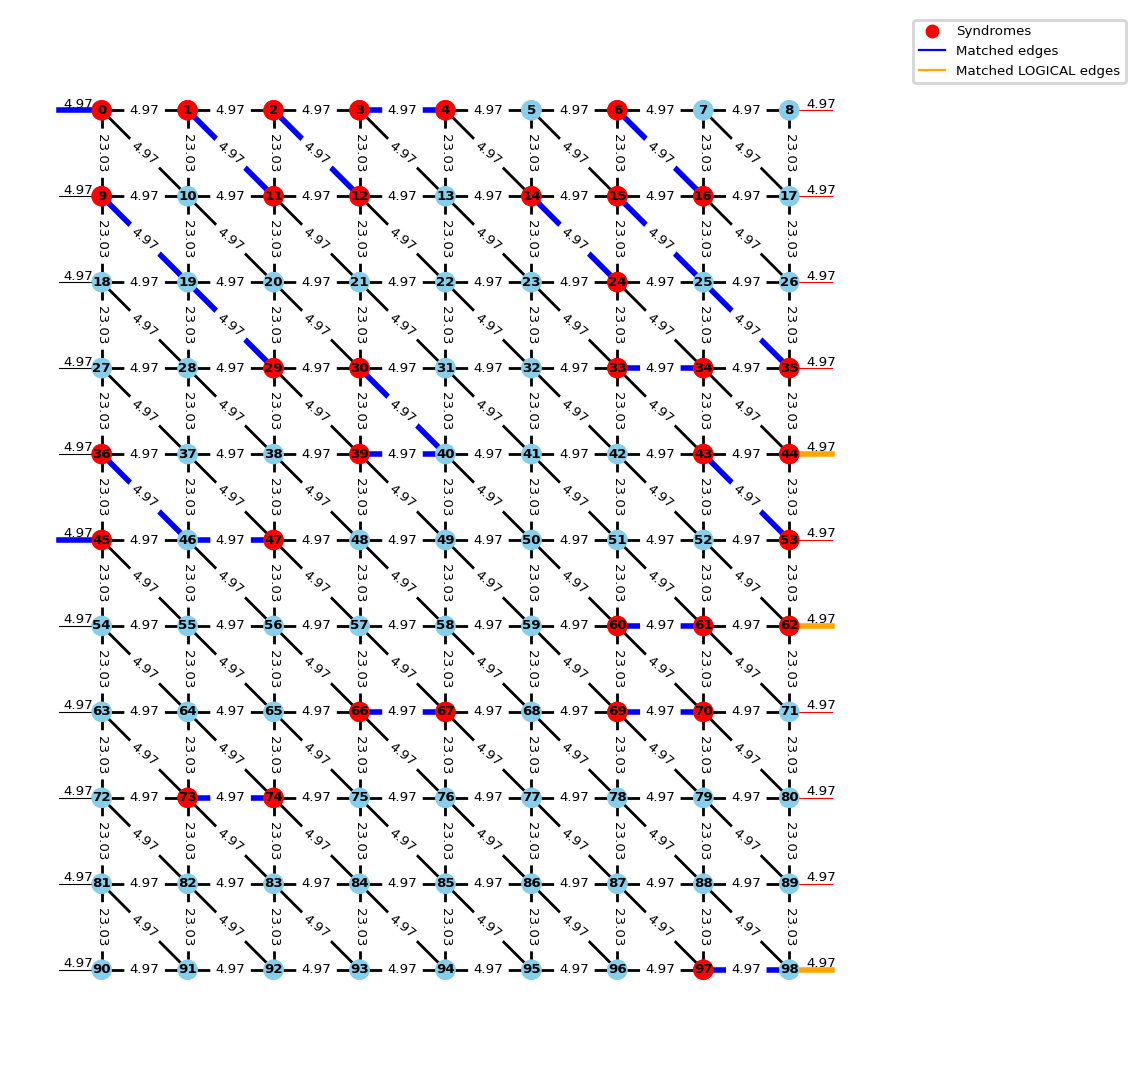

For common indices 17 in all lists: [1, 2, 3, 36, 72, 10, 78, 17, 81, 20, 52, 54, 56, 26, 60, 31]

result IQ:
Error 17 is at index 8 of [1, 2, 3, 7, 9, 10, 14, 15, 17, 20, 21, 26, 27, 31, 35, 36, 39, 46, 47, 52, 54, 56, 58, 59, 60, 63, 69, 72, 78, 81, 94, 96, 97, 99]


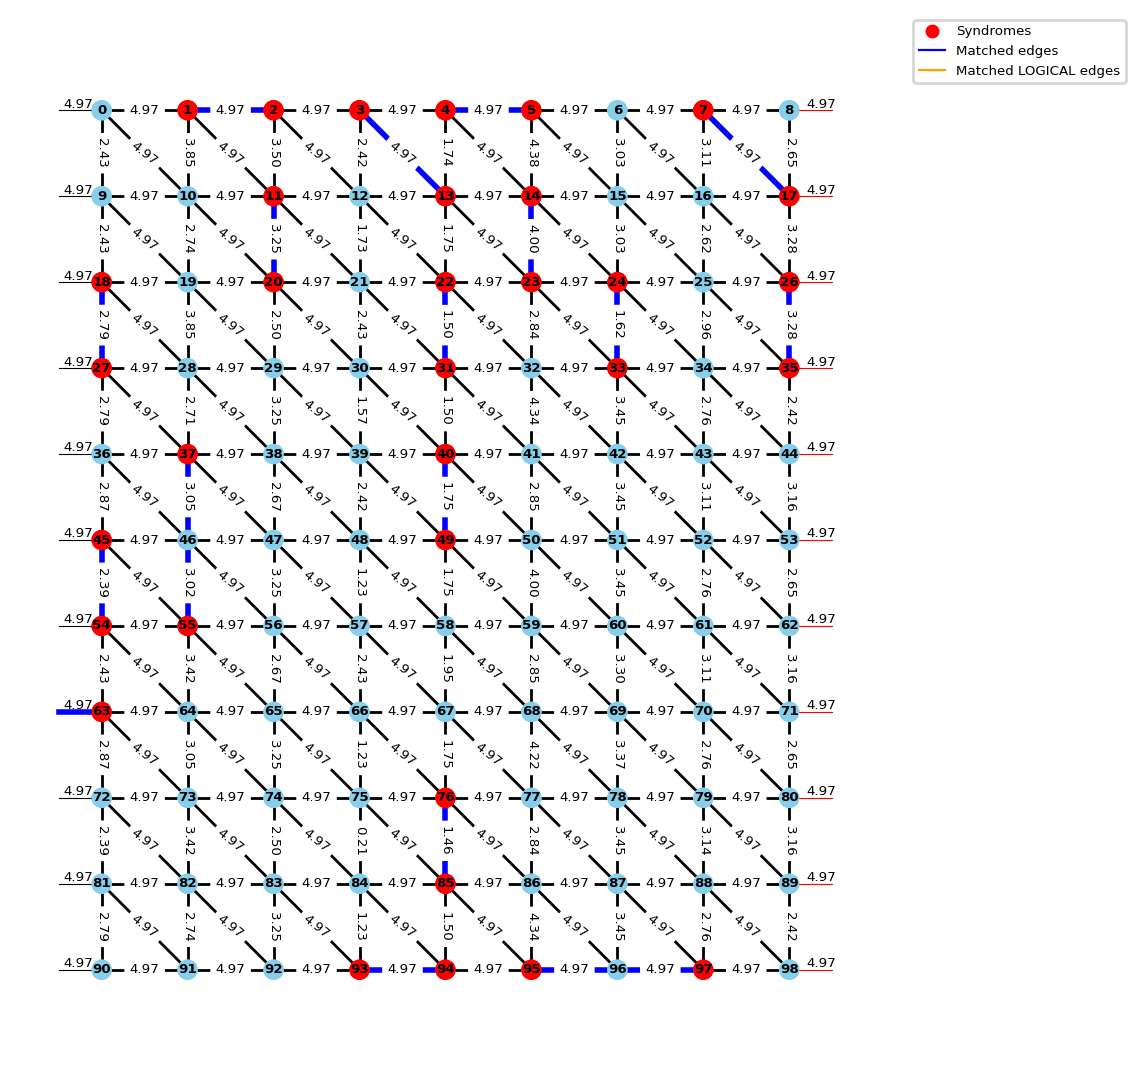


result_flat:
Error 17 is at index 8 of [1, 2, 3, 7, 9, 10, 13, 14, 17, 20, 21, 22, 26, 28, 31, 33, 36, 38, 43, 44, 47, 52, 54, 55, 56, 57, 60, 61, 62, 66, 69, 72, 73, 78, 79, 81, 86, 89, 90, 91, 94, 96]


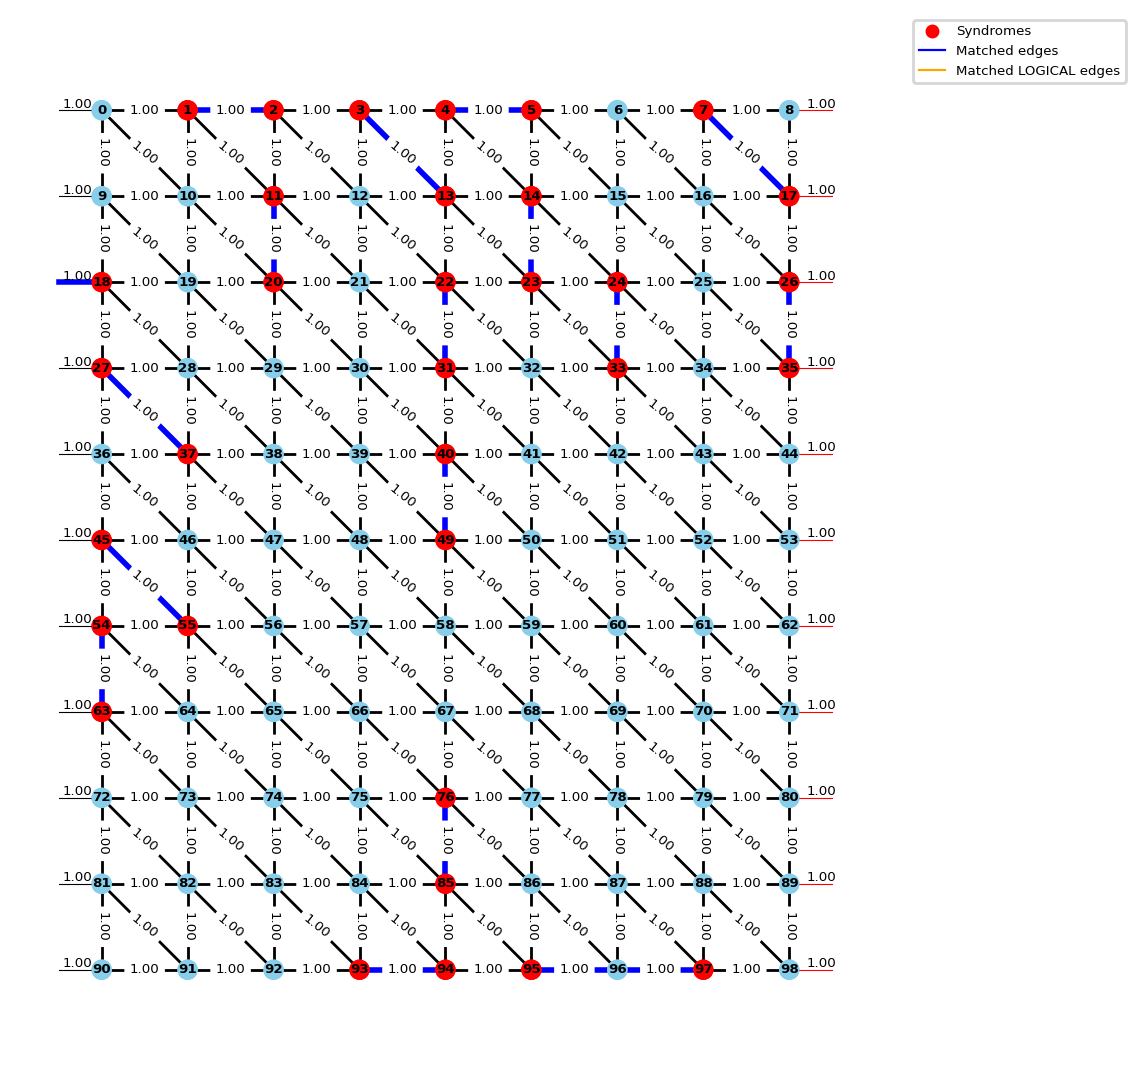


result_informed:
45 45
Error 17 is at index 6 of [1, 2, 3, 4, 10, 11, 17, 20, 22, 24, 26, 28, 31, 33, 34, 35, 36, 38, 39, 40, 42, 43, 45, 48, 52, 53, 54, 56, 57, 60, 61, 62, 65, 66, 70, 72, 78, 79, 81, 82, 85, 86, 88, 89, 98]


KeyboardInterrupt: 

In [80]:
scale_factor = 0.4
figsize = (13*scale_factor, 13*scale_factor)
for i in common:
    print("For common indices", i, "in all lists:", common)
    print()

    print("result IQ:")
    find = np.where(np.array(result.indices) == i)[0][0]
    print("Error", i, "is at index", find, "of", result.indices)
    details = result.error_details[find]
    draw_matching_graph(matching=None, d=d, T=synd_rounds, syndromes=details.detection_syndromes,
                        matched_edges=details.matched_edges, figsize=figsize, scale_factor=scale_factor, edge_list=details.edges)
    
    print()
    print("result_flat:")
    find = np.where(np.array(result_flat.indices) == i)[0][0]
    print("Error", i, "is at index", find, "of", result_flat.indices)
    details = result_flat.error_details[find]
    draw_matching_graph(matching=None, d=d, T=synd_rounds, syndromes=details.detection_syndromes,
                        matched_edges=details.matched_edges, figsize=figsize, scale_factor=scale_factor, edge_list=details.edges)


    print()
    print("result_informed:")
    find = np.where(np.array(result_informed.indices) == i)[0][0]
    print(len(result_informed.indices), len(result_informed.error_details))
    print("Error", i, "is at index", find, "of", result_informed.indices)
    details = result_informed.error_details[find]
    draw_matching_graph(matching=None, d=d, T=synd_rounds, syndromes=details.detection_syndromes,
                        matched_edges=details.matched_edges, figsize=figsize, scale_factor=scale_factor, edge_list=details.edges)